In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr
import numpy as np
import natsort
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

function_path = './functions/'
sys.path.append(function_path)
# from KCC_function import *
from Plot_function import *
from analysis_function import *
from obs_function import *

In [3]:
path = '/Users/tongli1997/Library/CloudStorage/OneDrive-UniversityofVictoria/Codes_run_on_local/Global_regional_attribution/Dec_2025/input_file/'
#### Grid monthly analysis data
# name = 'HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc'
# f = xr.open_dataset(path + name)
# tas_had = f['tas_mean'].rename({'latitude': 'lat','longitude': 'lon'})

#### Non-infilled data
name = 'HadCRUT.5.0.2.0.non-infilled.anomalies.ensemble_mean.nc'
f = xr.open_dataset(path + name)
tas_had_nan = f['tas_mean'].rename({'latitude': 'lat','longitude': 'lon'})
tas_had_reshaped_nan = tas_had_nan.groupby('time.year').apply(lambda x: x.groupby('time.month').mean())
tas_had_yr_mon_nan = tas_had_reshaped_nan.transpose('year', 'month', 'lat', 'lon')


In [4]:
tas_had_yr_mon_nan

<xarray.DataArray 'tas_mean' (year: 175, month: 12, lat: 36, lon: 72)> Size: 44MB
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], shape=(175, 12, 36, 72))
Coordinates:
  * lat          (lat) float64 288B -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon          (lon) float64 576B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    realization  int64 8B 100
  * year         (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024
Attributes:
    long_name:     blended air_temperature_anomaly over land with sea_water_t...
    units:         K
    cell_methods:  area: mean (interval: 5.0 degrees_north 5.0 degrees_east) ...

### Quality control for grid

#### On each grid, we require at least one month per quarter, three-quarters per year

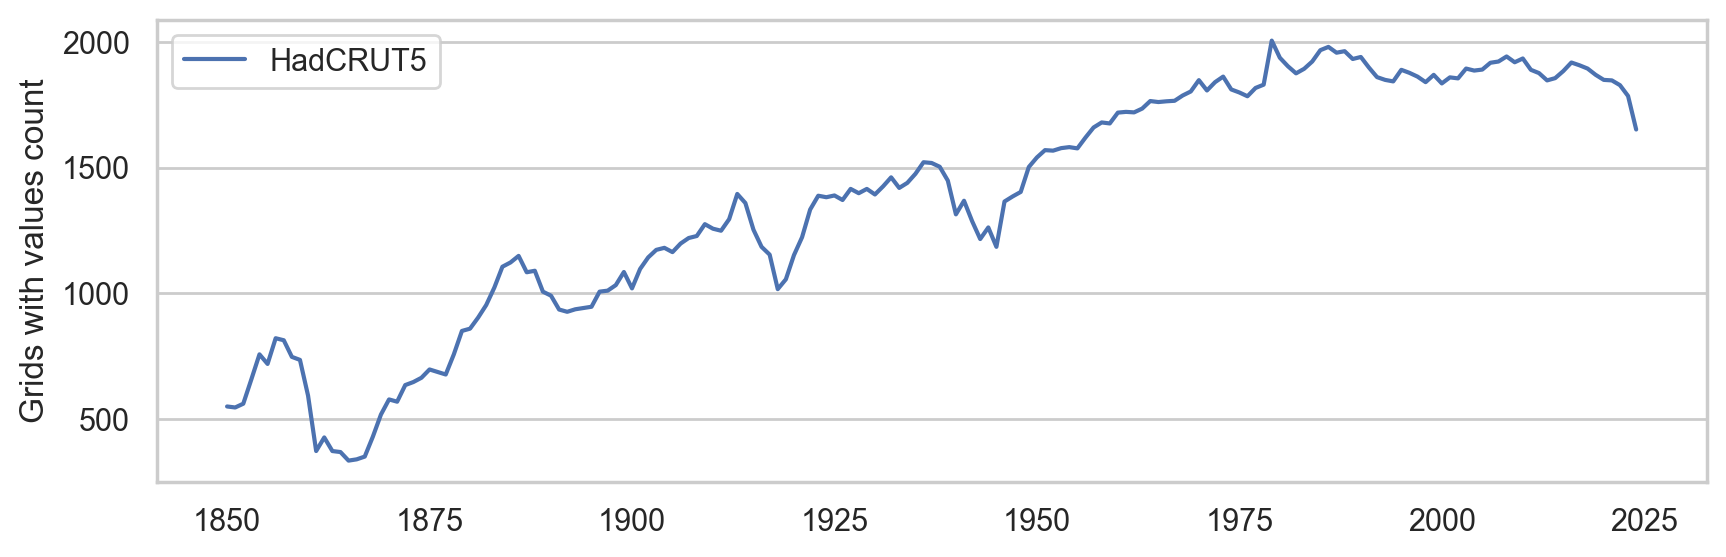

In [5]:
tas_had_yr_75per = filter_years_with_valid_quarters(tas_had_yr_mon_nan, min_valid_quarters=3)

notnan_counts_grid_had, notnan_percent_had = notnan_count(tas_had_yr_75per)

fig = plt.figure(figsize=(10, 3),dpi = 200)
sns.set_theme(style="whitegrid", rc={"axes.grid.axis": "y"})
plt.plot(notnan_counts_grid_had['year'], notnan_counts_grid_had, label = 'HadCRUT5')
plt.legend()
# plt.ylim(0,1)
plt.ylabel('Grids with values count')
plt.show()

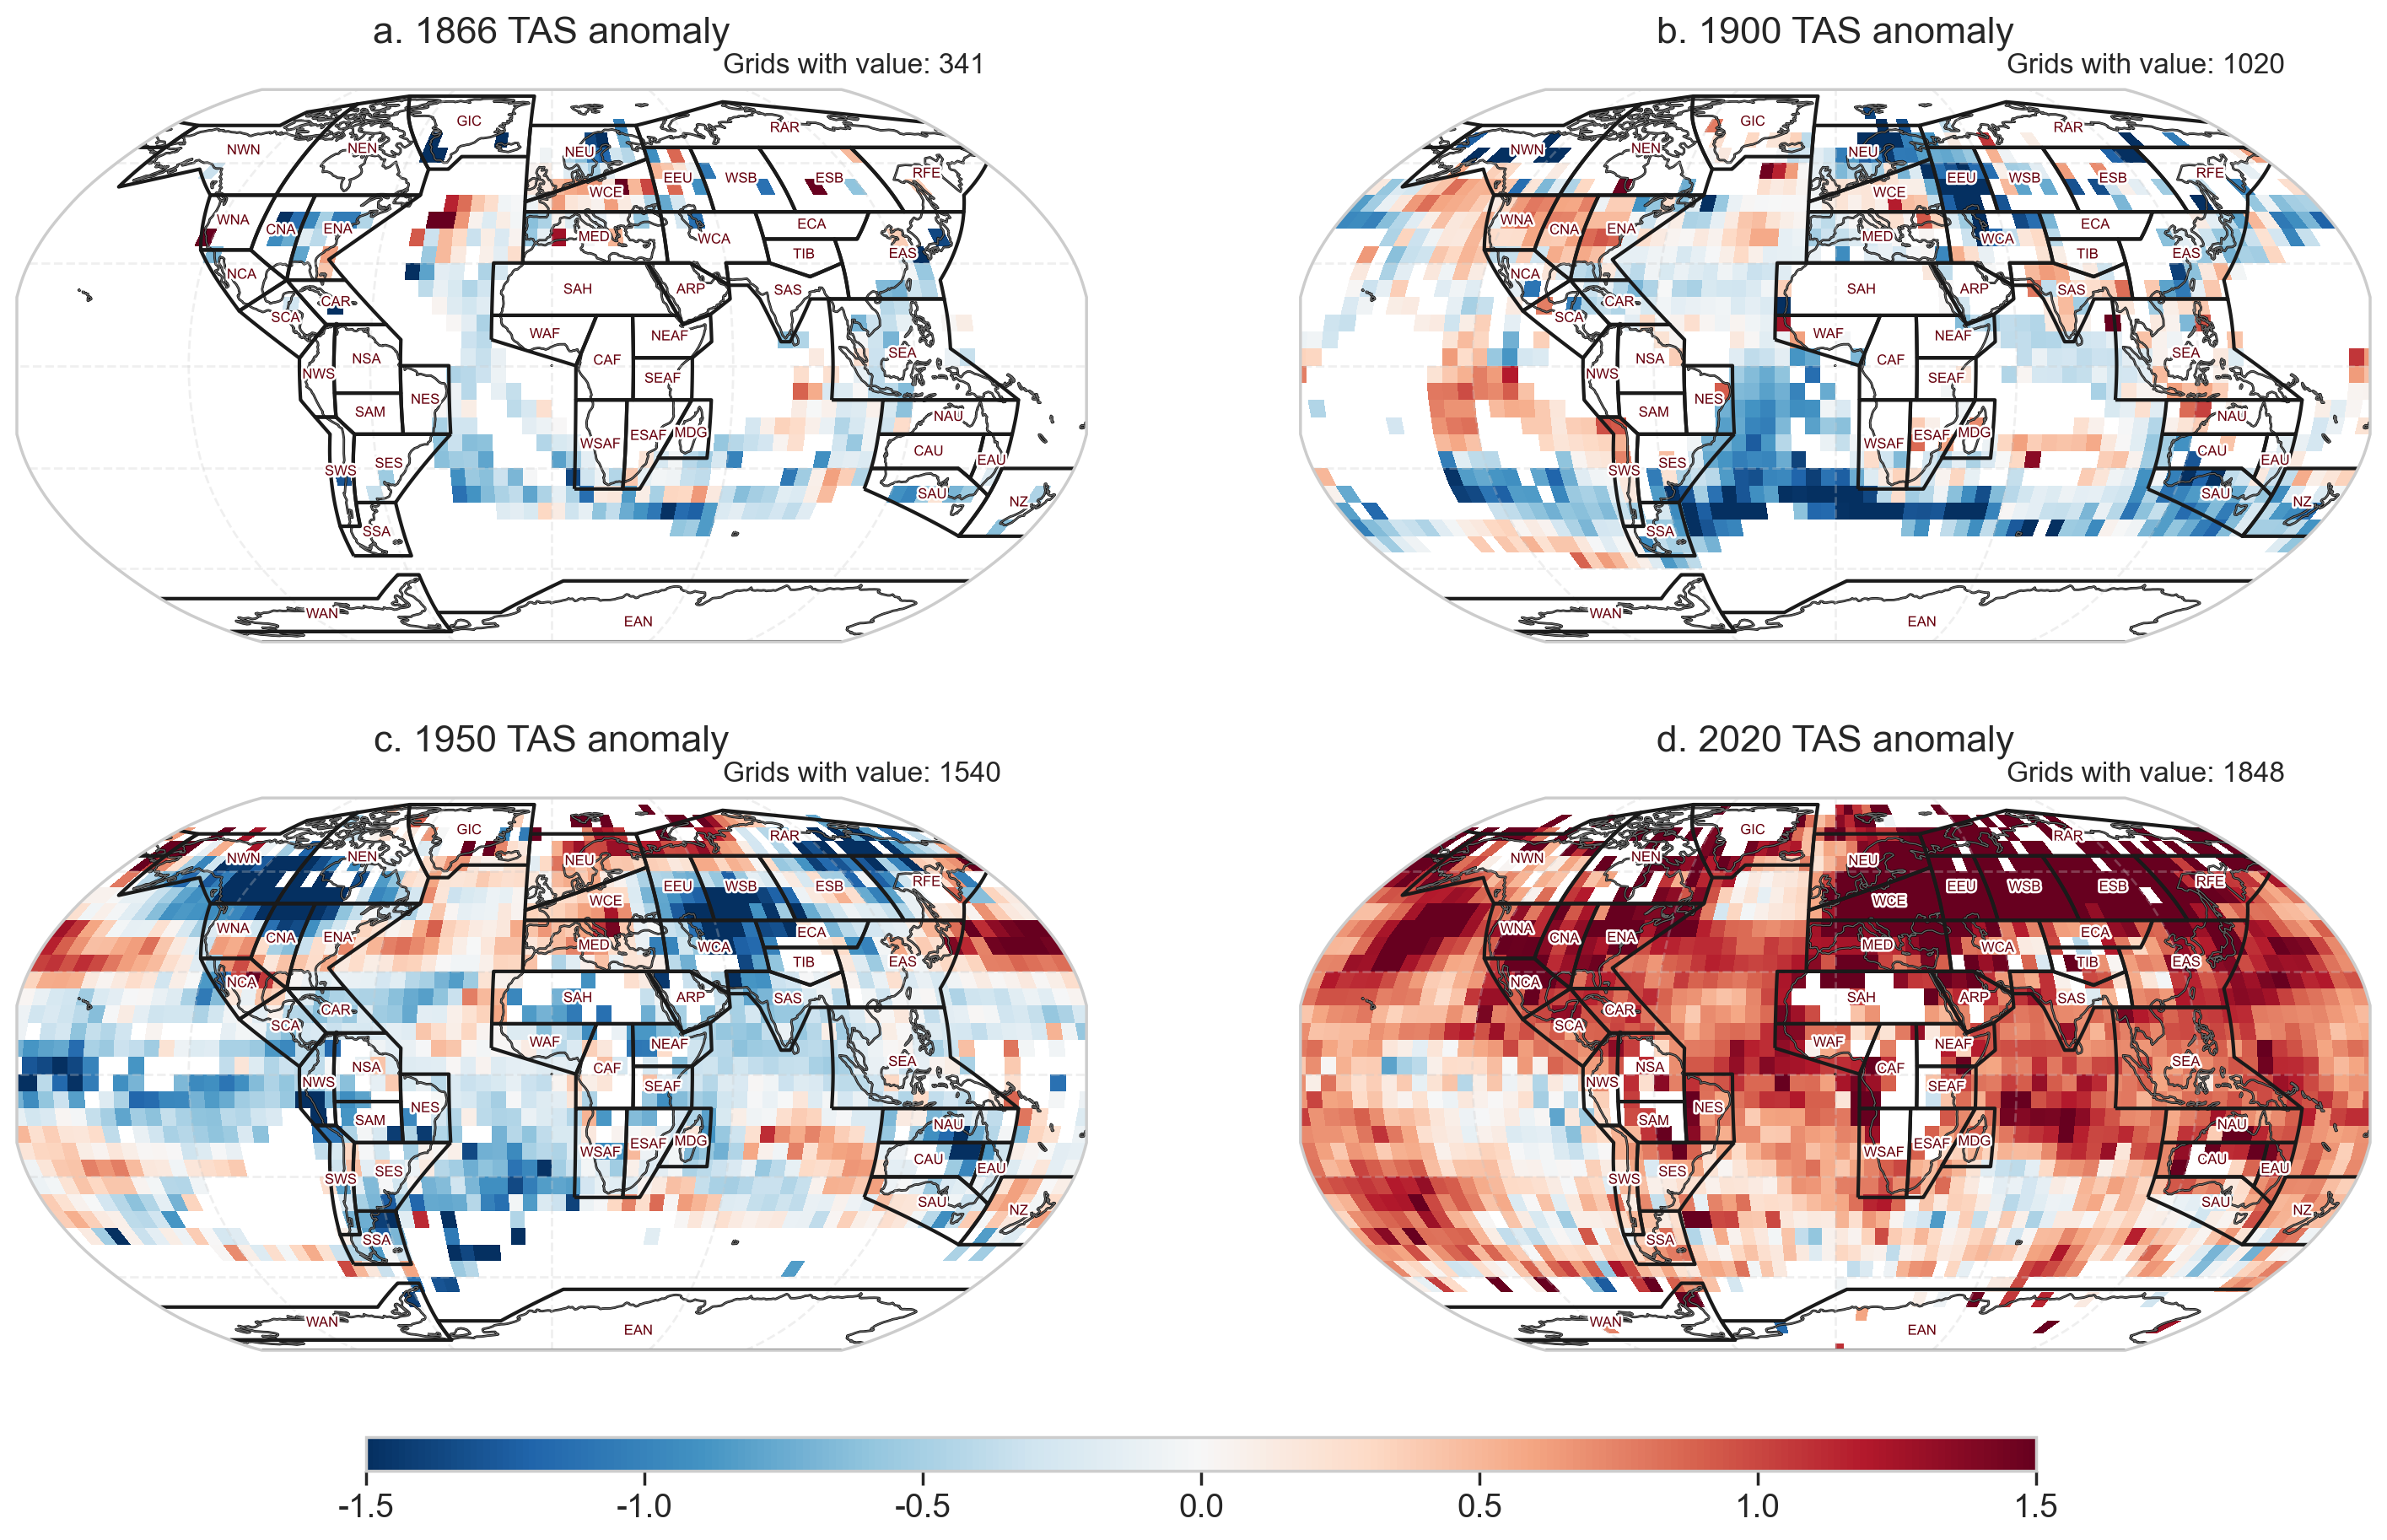

In [6]:
years = [1866, 1900, 1950, 2020]

plot_tas_anomaly_maps(tas_had_yr_75per, years, notnan_counts_grid_had, 
                          cmap=plt.cm.RdBu_r, vmin=-1.5, vmax=1.5, 
                          proj=ccrs.Robinson(), figsize=(18, 10), dpi=200)

### Calculate the AR6 regional mean

In [7]:
tas_nan_yr_AR6_had, tas_regional_nonmask_AR6_had, grid_per_region_AR6_had, tas_regional_mask_AR6_had = calculate_regional_nan_years_map(
    tas_grid=tas_had_yr_75per,  # 3D array with dims (year, lat, lon)
    threshold=0.75
)

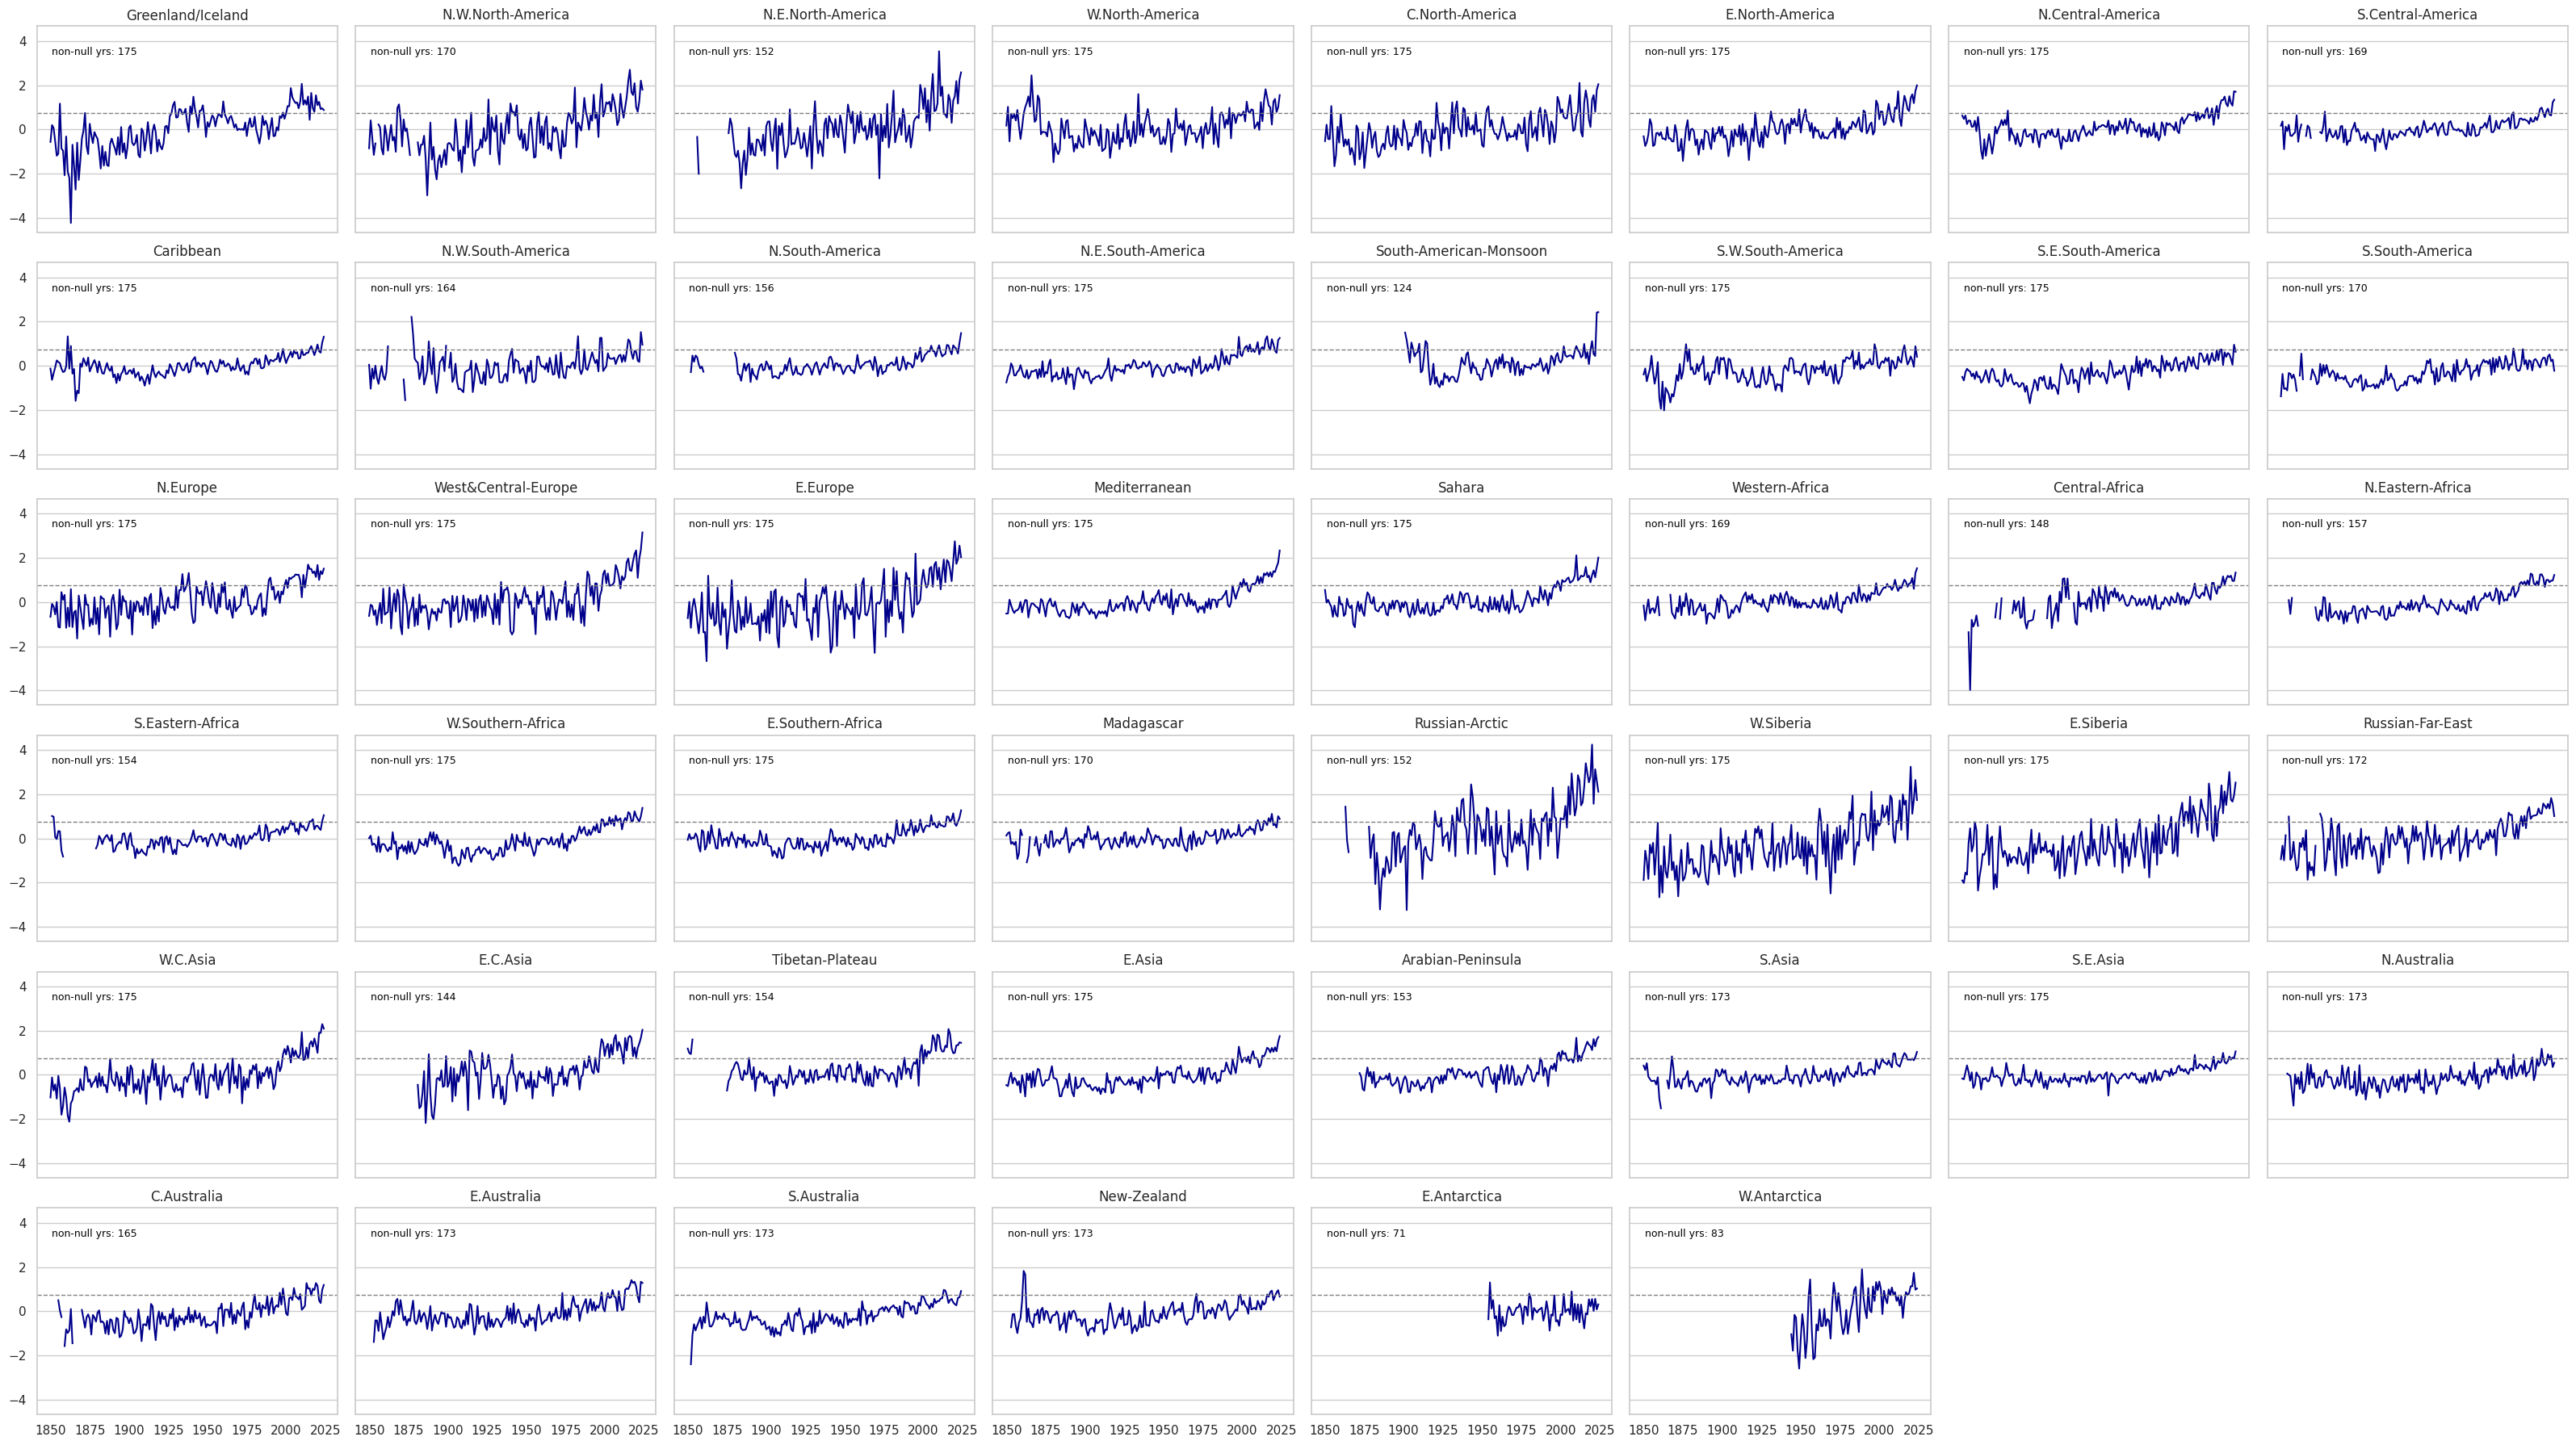

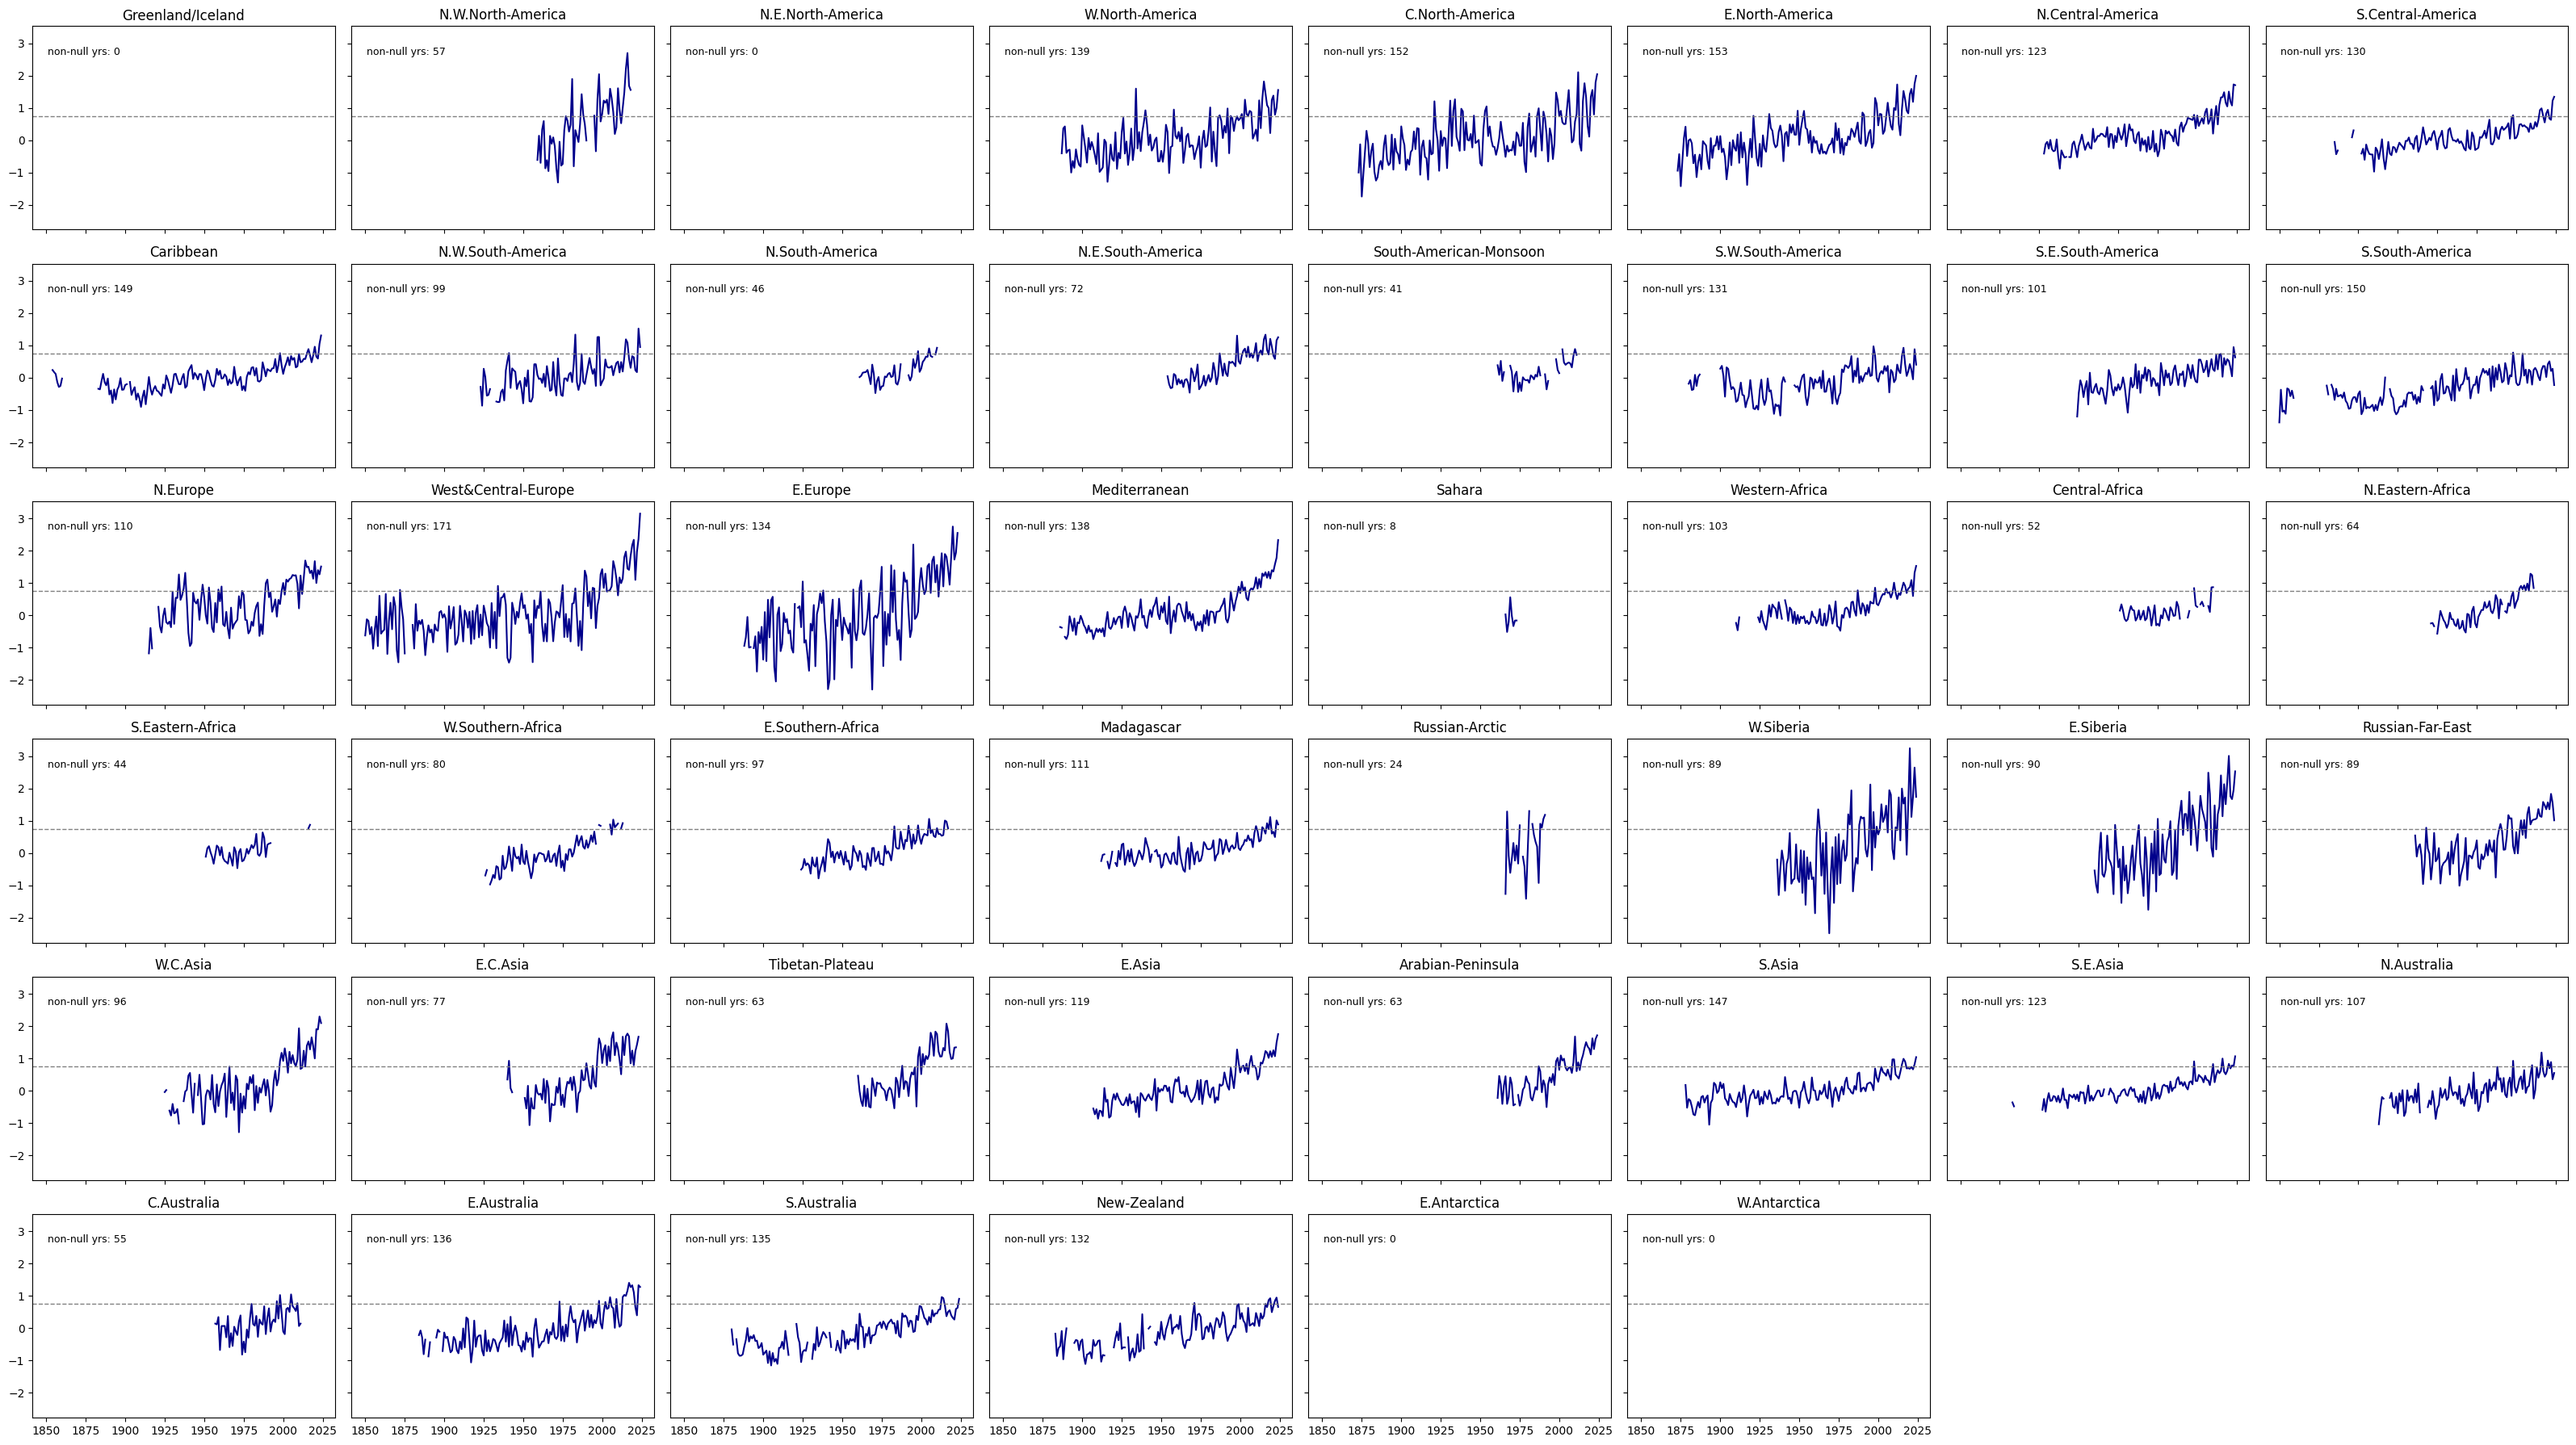

In [8]:
region_names = tas_regional_mask_AR6_had.coords['names'].values

plot_regional_timeseries(
    tas_regional_nonmask_AR6_had,
    region_coord='region',
    time_coord='year',
    region_names=region_names,
    ncols=8,
    yline=0.75
)
plt.show()
plot_regional_timeseries(
    tas_regional_mask_AR6_had,
    region_coord='region',
    time_coord='year',
    region_names=region_names,
    ncols=8,
    yline=0.75
)

plt.show()

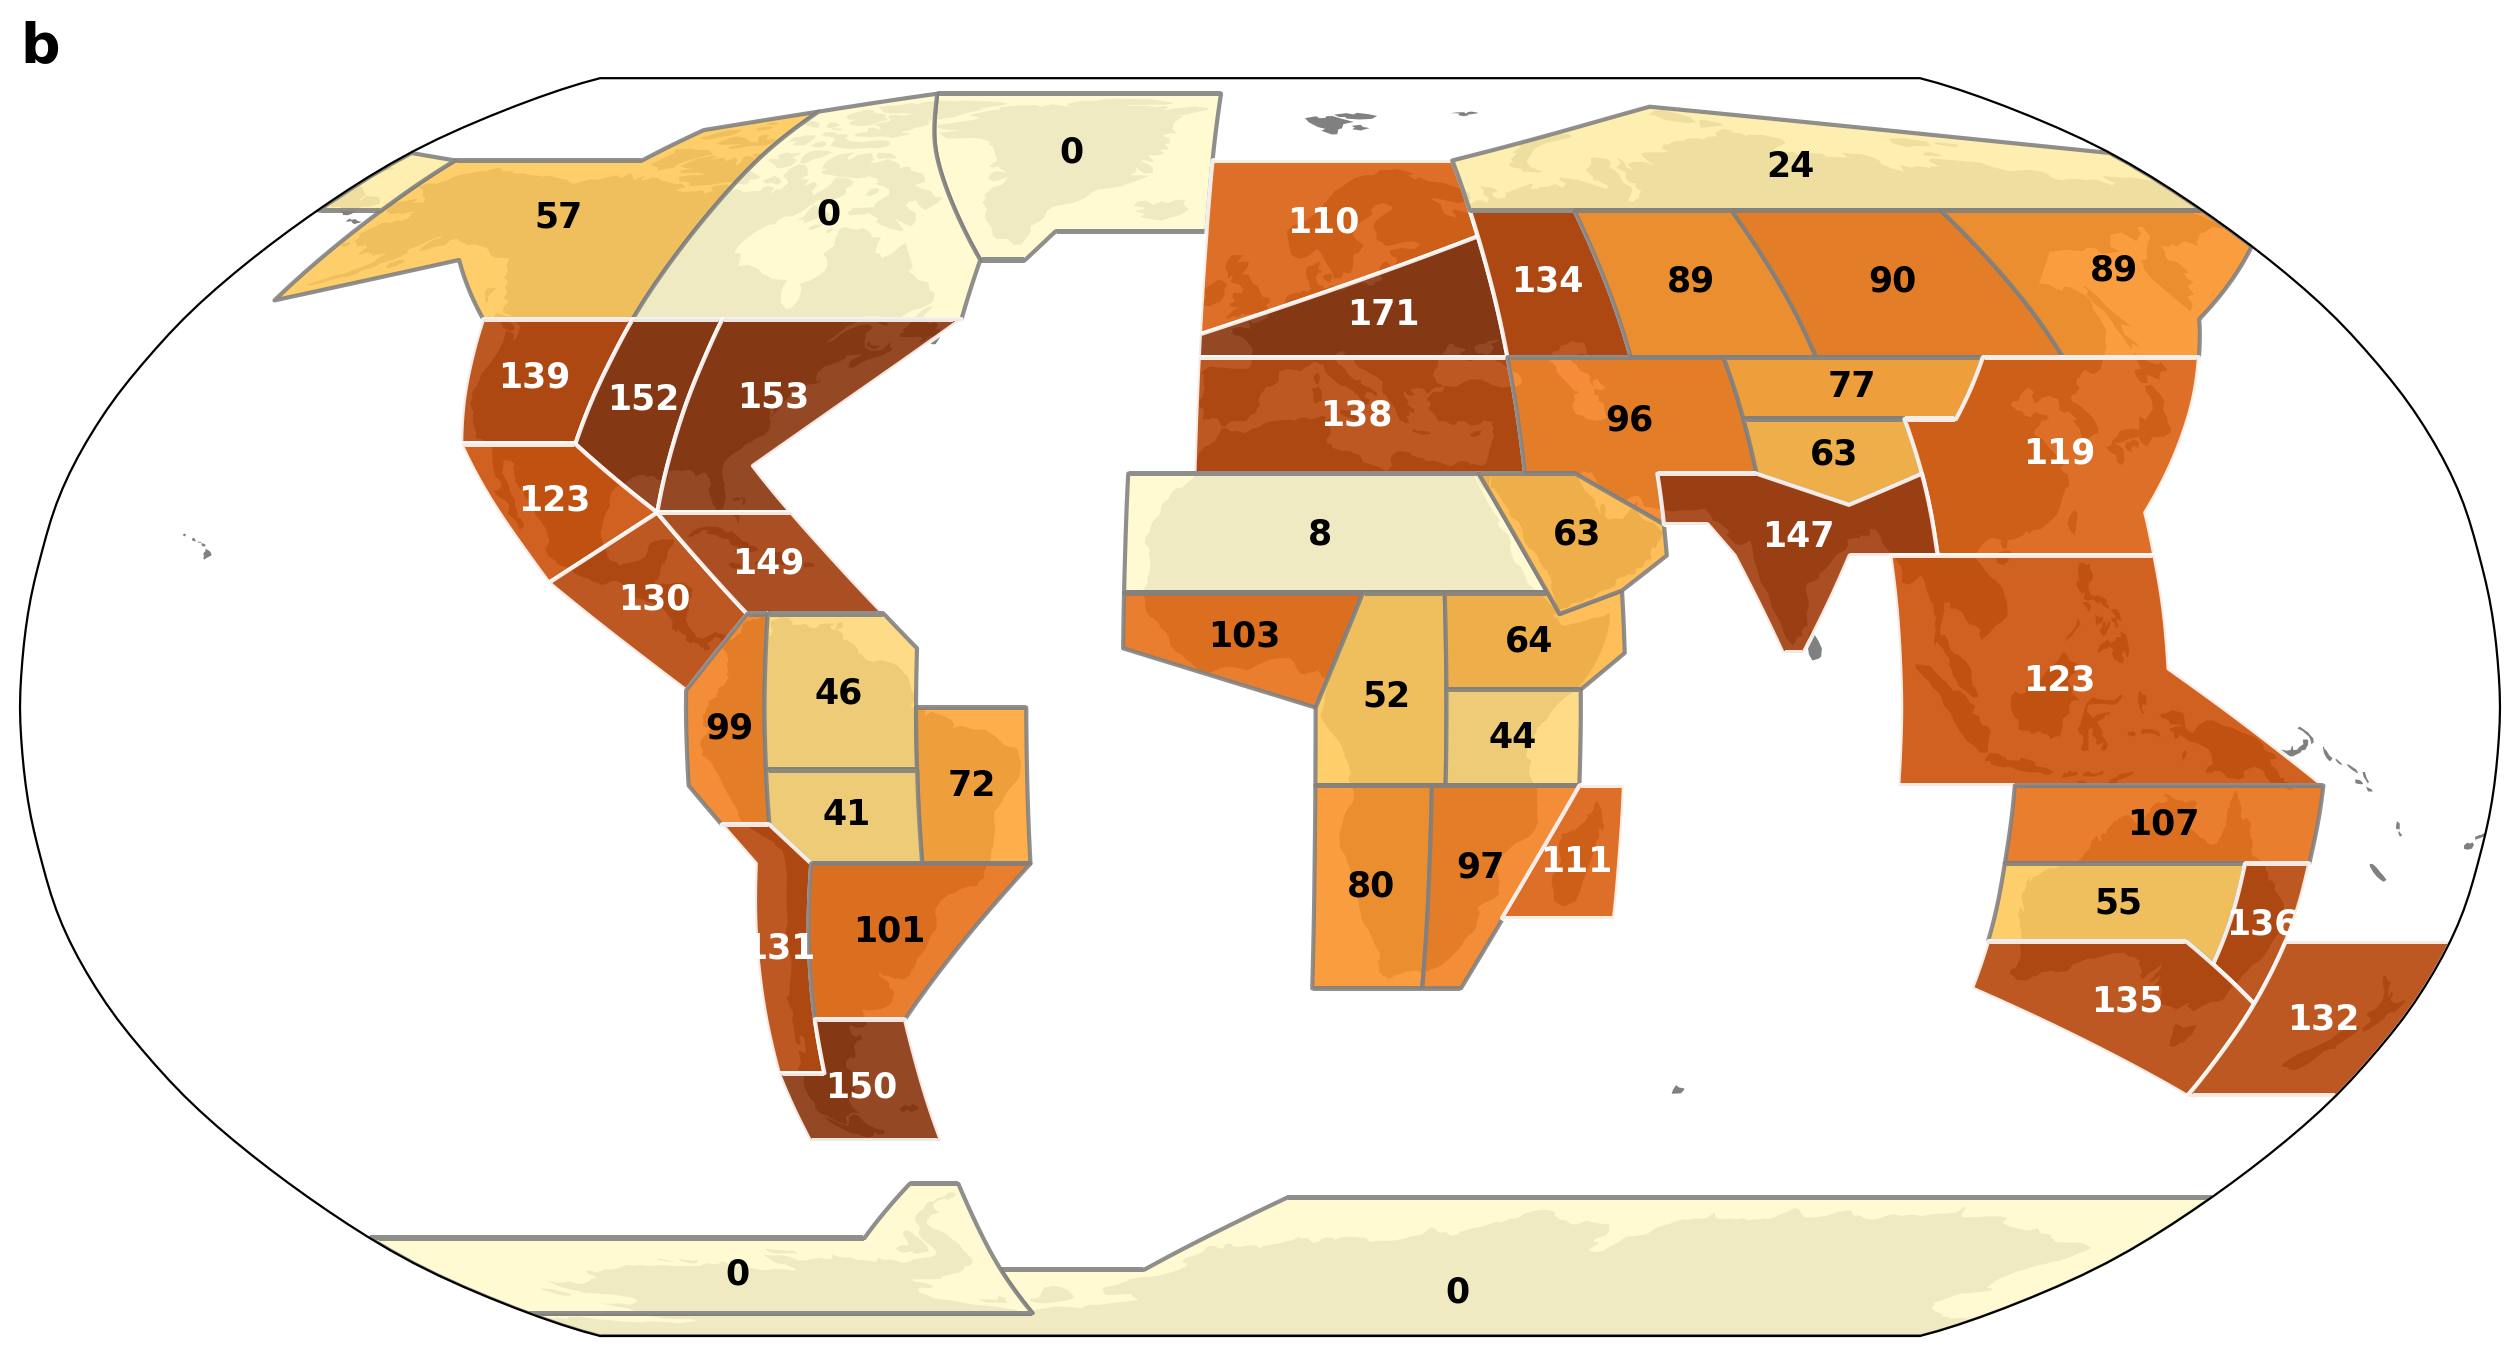

In [9]:
# Shared colorbar
cmap = sns.color_palette("YlOrBr", as_cmap=True)
colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[20:236]
truncated_cmap = colors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)

import matplotlib.colors as mcolors

# --- Plot panels ---
fig, axes = plt.subplots(1,1, figsize=(16, 16), subplot_kw={'projection': ccrs.Robinson()}, dpi=200)

axes.set_global()

bounds = np.arange(0, 160+10, 10)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

norm0 = plot_ar6_region_data_on_ax(axes, tas_nan_yr_AR6_had, cmap=truncated_cmap, norm=norm, decimals = 0)
axes.set_title("b", fontsize=20, fontweight='bold', loc='left')


# --- Shared colorbar ---
# Use a ScalarMappable with the colormap and norm
# sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm0)
# sm.set_array([])  # required for ScalarMappable

# cb = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, shrink=0.4)
# cb.ax.tick_params(labelsize=14)

# cb.set_label("Number of valid grids")

plt.show()

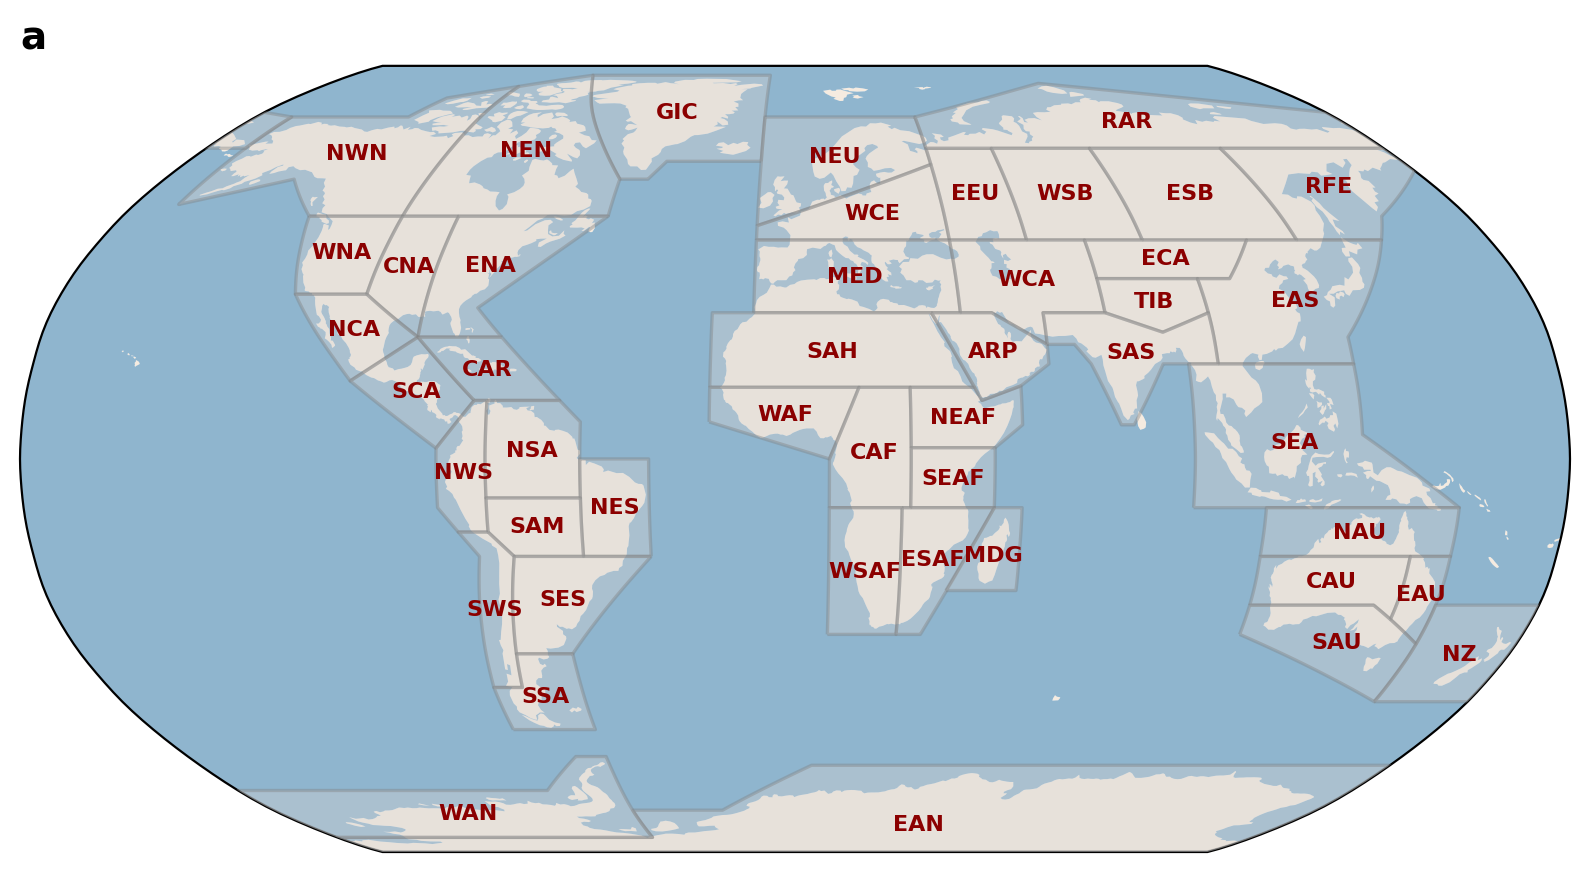

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import geopandas as gpd
import regionmask
import matplotlib.patheffects as pe
from shapely.geometry import shape
import cartopy.feature as cfeature

# --- Prepare AR6 GeoDataFrame ---
ar6_regions = regionmask.defined_regions.ar6.land
ar6_gdf = gpd.GeoDataFrame({
    "region": ar6_regions.abbrevs,
    "geometry": [shape(p) for p in ar6_regions.polygons]
}, crs="EPSG:4326")

# --- Plotting ---
fig = plt.figure(figsize=(10, 8), dpi=200)
proj = ccrs.Robinson()
ax = fig.add_subplot(1,1,1, projection=proj)

ax.set_global()

# Add land background
ax.add_feature(cfeature.LAND, facecolor="#f5ebe0", linewidth=0)
ax.add_feature(cfeature.OCEAN, facecolor="#6096ba", alpha = 0.7, linewidth=0)

# --- Draw AR6 polygons ---
ar6_gdf.to_crs(proj.proj4_init).plot(
    ax=ax,
    edgecolor="gray",
    facecolor="lightgray",
    linewidth=1.2,
    zorder=3,
    alpha = 0.4

)

# --- Add AR6 region labels ---
for i, abbrev in enumerate(ar6_regions.abbrevs):
    lon, lat = ar6_regions.centroids[i]
    ax.text(
        lon, lat,
        abbrev,
        transform=ccrs.PlateCarree(),
        ha="center", va="center",
        fontsize=8,
        color="darkred",
        weight='bold',
    )

plt.title(
    "a",
    loc="left",
    fontsize=14,
    fontdict={"size": "large", "weight": "bold"}
)

plt.show()

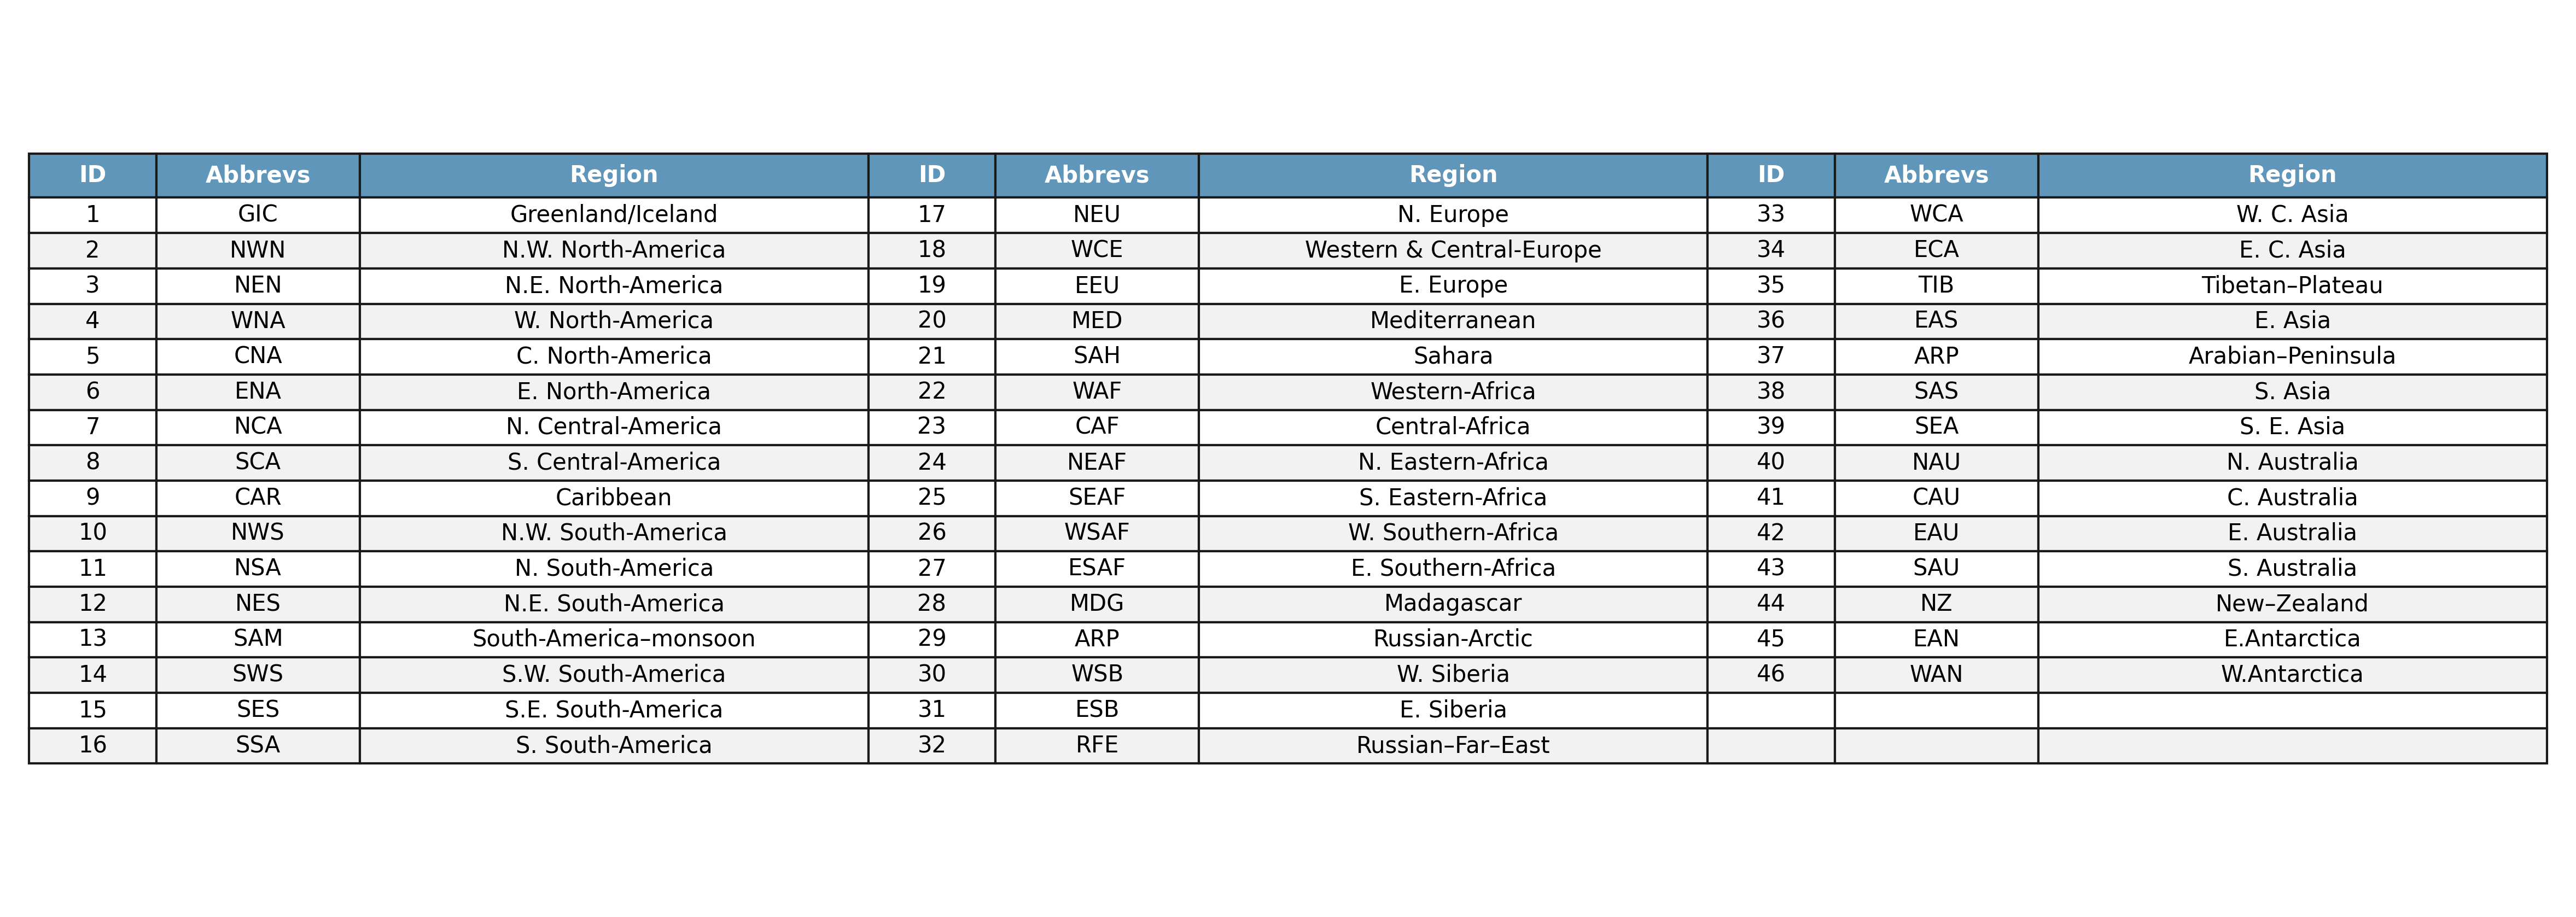

In [19]:
# Create the table data from the screenshot
data = {
    "ID": list(range(1,47)),
    "Abbrevs": ["GIC","NWN","NEN","WNA","CNA","ENA","NCA","SCA","CAR","NWS","NSA","NES","SAM","SWS","SES",
             "SSA","NEU","WCE","EEU","MED","SAH","WAF","CAF","NEAF","SEAF","WSAF","ESAF","MDG","ARP","WSB",
             "ESB","RFE","WCA","ECA","TIB","EAS","ARP","SAS","SEA","NAU","CAU","EAU","SAU","NZ","EAN", "WAN"],
    "Region": ["Greenland/Iceland","N.W. North-America","N.E. North-America","W. North-America","C. North-America",
               "E. North-America","N. Central-America","S. Central-America","Caribbean","N.W. South-America",
               "N. South-America","N.E. South-America","South-America–monsoon","S.W. South-America",
               "S.E. South-America","S. South-America","N. Europe","Western & Central-Europe","E. Europe",
               "Mediterranean","Sahara","Western-Africa","Central-Africa","N. Eastern-Africa","S. Eastern-Africa",
               "W. Southern-Africa","E. Southern-Africa","Madagascar","Russian-Arctic","W. Siberia","E. Siberia",
               "Russian–Far–East","W. C. Asia","E. C. Asia","Tibetan–Plateau","E. Asia","Arabian–Peninsula",
               "S. Asia","S. E. Asia","N. Australia","C. Australia","E. Australia","S. Australia","New–Zealand","E.Antarctica","W.Antarctica"]
}


df = pd.DataFrame(data)

# Calculate rows needed for 3 columns
n_items = len(df)
n_rows = int(np.ceil(n_items / 3))

# Reshape data into 3 columns
reshaped_data = []
for i in range(n_rows):
    row = []
    for col in range(3):
        idx = i + col * n_rows
        if idx < n_items:
            # Add all column values from the original dataframe
            row.extend(df.iloc[idx].values)
        else:
            # Add empty cells if we've run out of data
            row.extend([''] * len(df.columns))
    reshaped_data.append(row)

# Create new column labels (repeat original labels 3 times)
new_columns = list(df.columns) * 3

# Create new dataframe
df_3col = pd.DataFrame(reshaped_data, columns=new_columns)

# Plot the figure with the new layout
fig, ax = plt.subplots(figsize=(20, 7), dpi = 300)  # Increased width
ax.axis('off')

table = ax.table(
    cellText=df_3col.values,
    colLabels=df_3col.columns,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.4)

# Style the header row
for i in range(len(df_3col.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#6096ba')  # Blue background for headers
    cell.set_text_props(weight='bold', color='white', va='center')  # White bold text
    cell.set_height(0.05)

# Style the data rows (alternating colors)
for i in range(1, len(df_3col) + 1):
    for j in range(len(df_3col.columns)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#F2F2F2')  # Light gray for even rows
        else:
            cell.set_facecolor('white')  # White for odd rows
        cell.set_text_props(color='black', va='center')  # Black text
        cell.set_height(0.04)

### --------------------
# column index → width
width_map = {
    0: 0.05,  # ID columns
    3: 0.05,
    6: 0.05,
    1: 0.08,
    4: 0.08,
    7: 0.08,
    2: 0.2,
    5: 0.2,
    8: 0.2,
}

nrows = len(df_3col) + 1  # include header

for r in range(nrows):
    for c, w in width_map.items():
        cell = table[(r, c)]
        cell.set_width(w)


plt.show()

### Continent scale mean

In [12]:
results = compute_continent_stats(tas_had_yr_75per, threshold=0.5)

continent_mask      = results["continent_mask"]
grid_count       = results["grid_count"]
grid_fraction    = results["grid_fraction"]
continent_means_complete  = results["continent_means"]
tas_continent_mask  = results["tas_continent_mask"]
nan_year_continent  = results["nan_year_continent"]

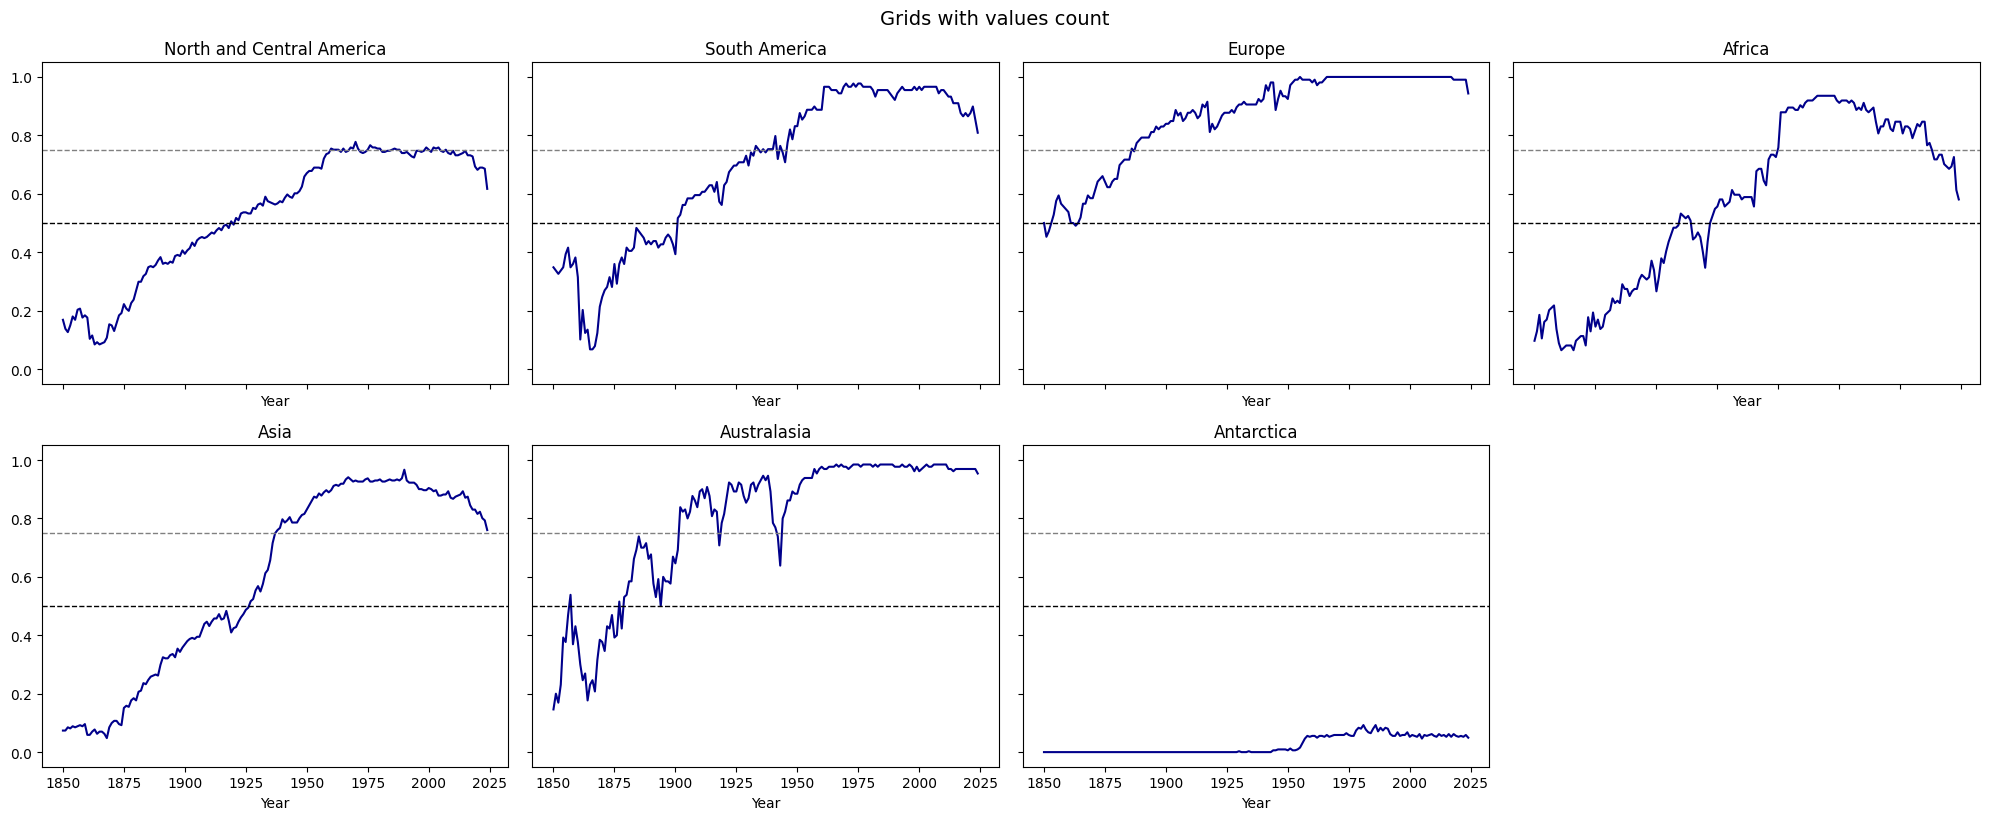

In [13]:
# Create figure with 8 subplots (e.g., 4 rows × 2 cols)
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.delaxes(axes[-1])  # This removes the last (8th) subplot

sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)
for i in range(7):
    ax = axes[i]
    tas_i = grid_fraction[i,:]  # Data for region i
    name = grid_fraction.continent.values[i]  # Get region name
    
    tas_i.plot(ax=ax, color = 'darkblue', linewidth=1.5)
    ax.axhline(0.75, color='gray', linestyle='--', linewidth=1)  # <-- add y=0.75 line
    ax.axhline(0.5, color='black', linestyle='--', linewidth=1)  # <-- add y=0.75 line

    ax.set_title(name)
    ax.set_xlabel("Year")
    # ax.set_ylabel("tas")

plt.tight_layout()
plt.suptitle("Grids with values count", fontsize=14, y=1.02)
plt.show()

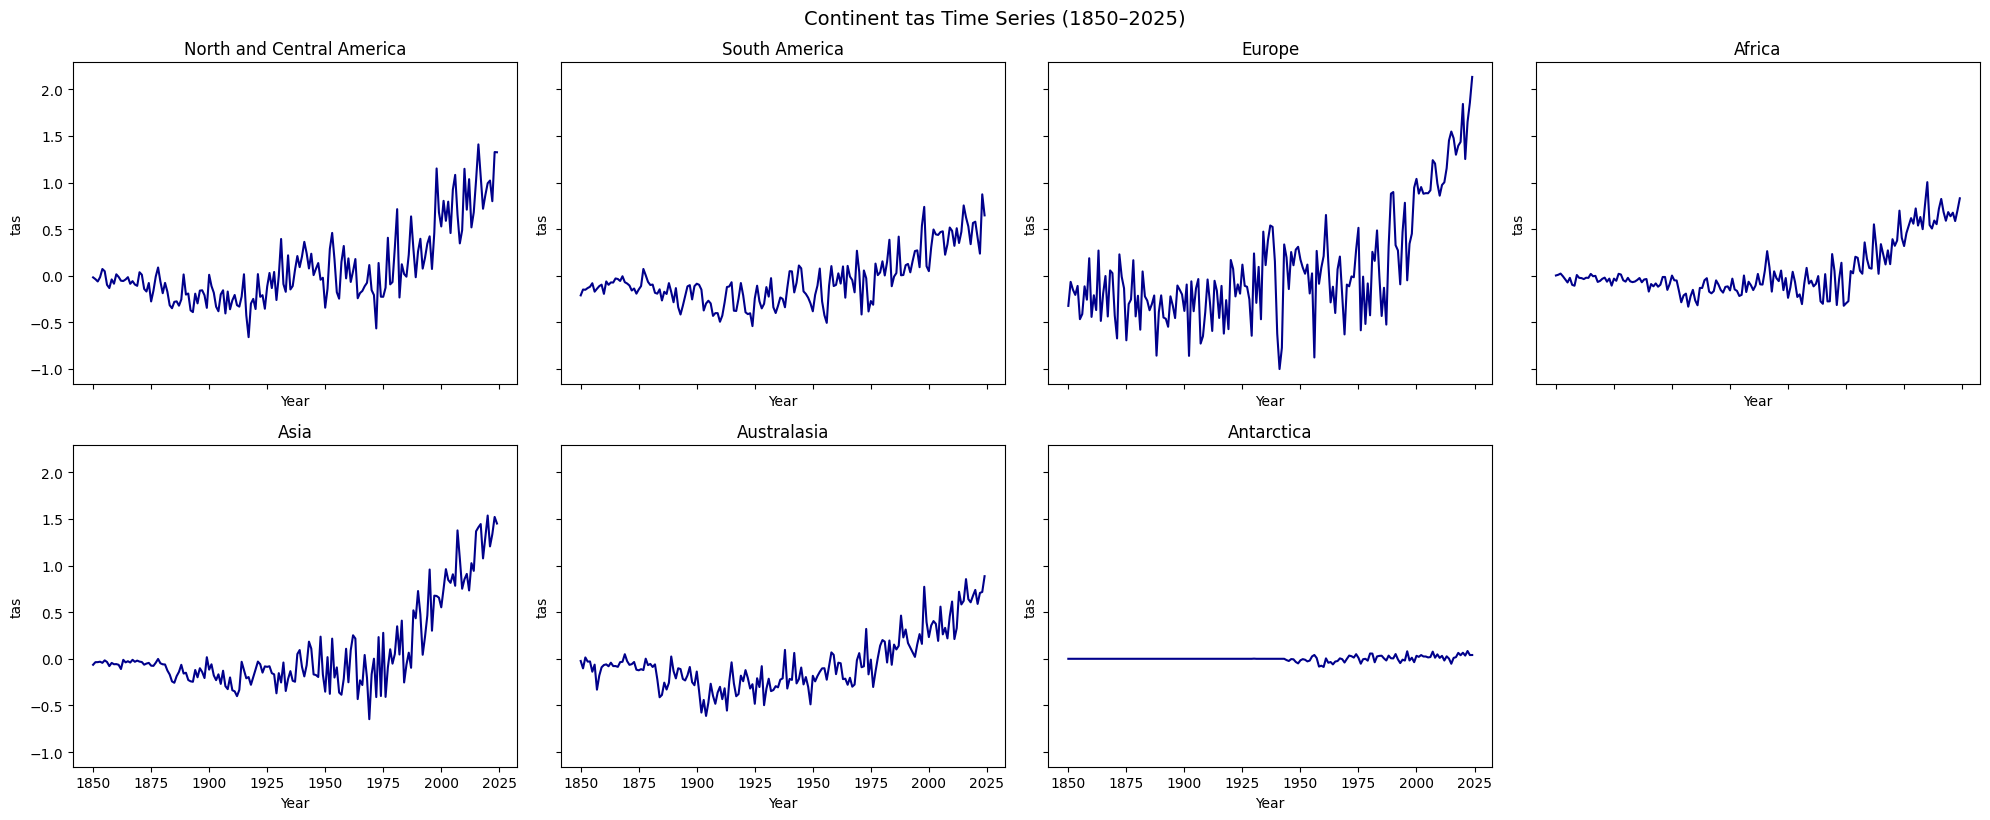

In [14]:
# Create figure with 8 subplots (e.g., 4 rows × 2 cols)
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.delaxes(axes[-1])  # This removes the last (8th) subplot

for i in range(7):
    ax = axes[i]
    tas_i = continent_means_complete[i,:]  # Data for region i
    name = continent_means_complete.continent.values[i]  # Get region name
    
    tas_i.plot(ax=ax, color = 'darkblue')
    ax.set_title(name)
    ax.set_xlabel("Year")
    ax.set_ylabel("tas")

plt.tight_layout()
plt.suptitle("Continent tas Time Series (1850–2025)", fontsize=14, y=1.02)
plt.show()

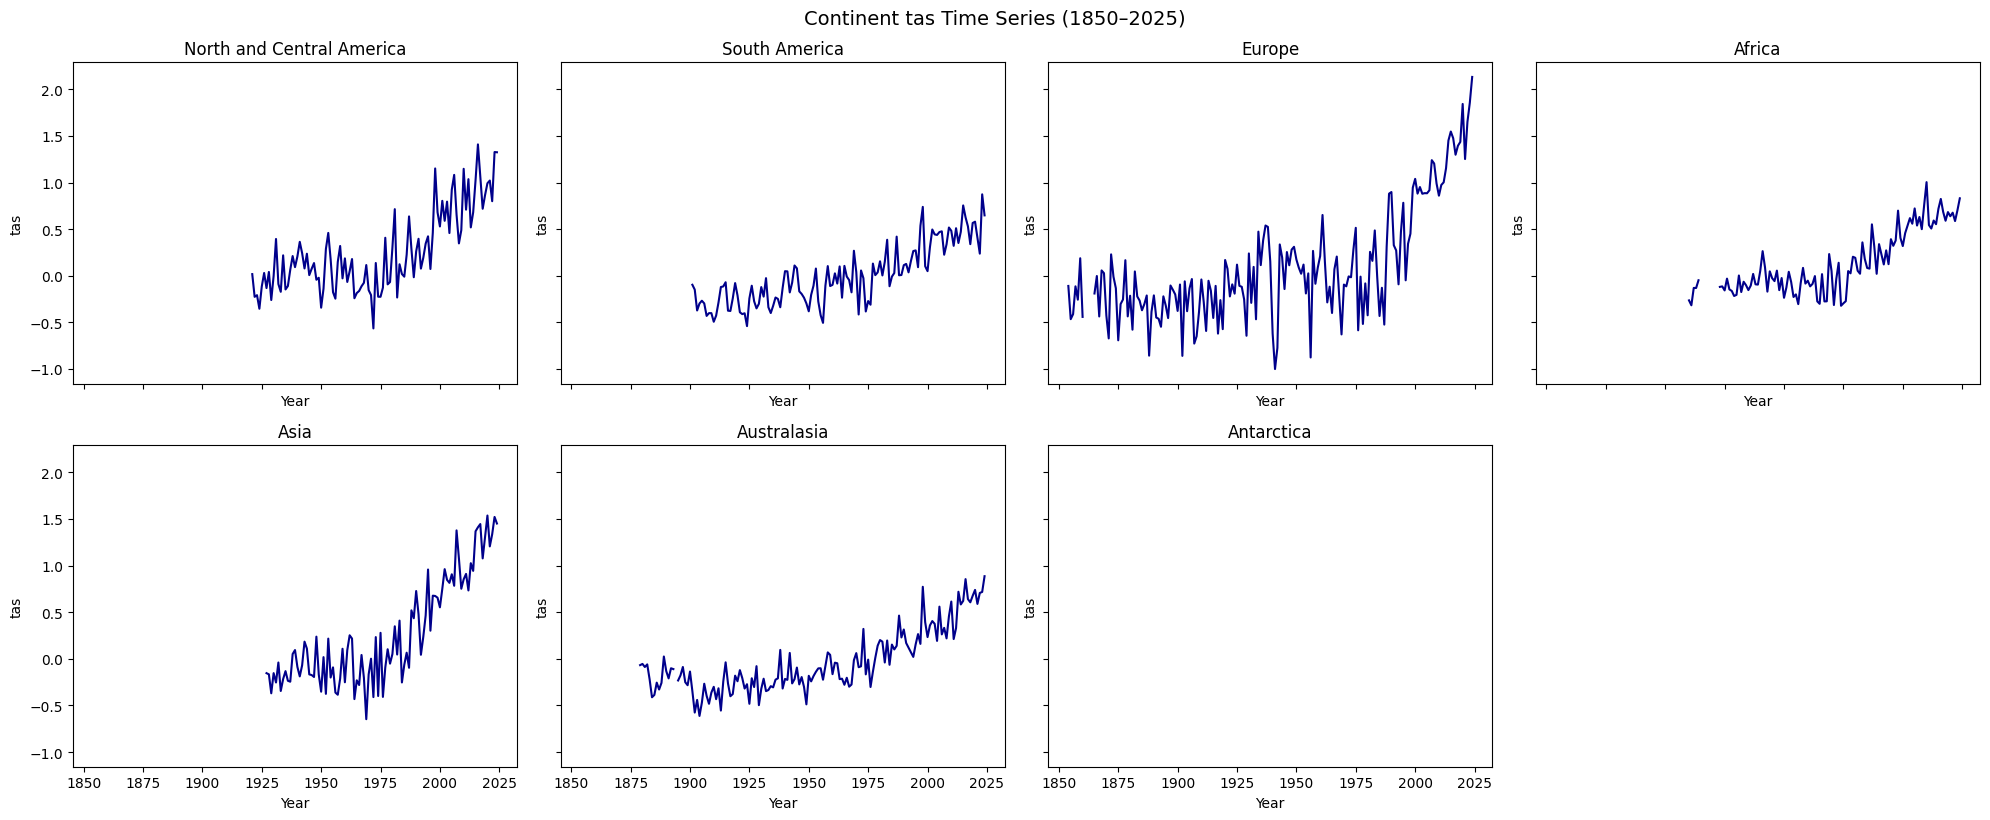

In [15]:
# Create figure with 8 subplots (e.g., 4 rows × 2 cols)
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.delaxes(axes[-1])  # This removes the last (8th) subplot

for i in range(7):
    ax = axes[i]
    tas_i = tas_continent_mask[i,:]  # Data for region i
    name = tas_continent_mask.continent.values[i]  # Get region name
    
    tas_i.plot(ax=ax, color = 'darkblue')
    ax.set_title(name)
    ax.set_xlabel("Year")
    ax.set_ylabel("tas")

plt.tight_layout()
plt.suptitle("Continent tas Time Series (1850–2025)", fontsize=14, y=1.02)
plt.show()

In [16]:
continents_to_ar6 = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN']
}

ar6_regions = regionmask.defined_regions.ar6.land

import geopandas as gpd
from shapely.ops import unary_union

clean_continent_polygons = []
clean_continent_names = []

for cont_name, ar6_list in continents_to_ar6.items():
    polys = [ar6_gdf.loc[ar6_gdf['region'] == r, 'geometry'].values[0] for r in ar6_list]

    # STEP 1 — union all polygons
    merged = unary_union(polys)

    # STEP 2 — buffer(0.05) closes micro gaps and removes overlaps
    merged = merged.buffer(0.05)

    # STEP 3 — simplify for cosmetic cleanup
    merged = merged.simplify(0.05, preserve_topology=True)

    # STEP 4 — buffer back to original size
    merged = merged.buffer(-0.05)

    clean_continent_polygons.append(merged)
    clean_continent_names.append(cont_name)

continent_gdf = gpd.GeoDataFrame(
    {"continent": clean_continent_names, "geometry": clean_continent_polygons},
    crs="EPSG:4326",
)

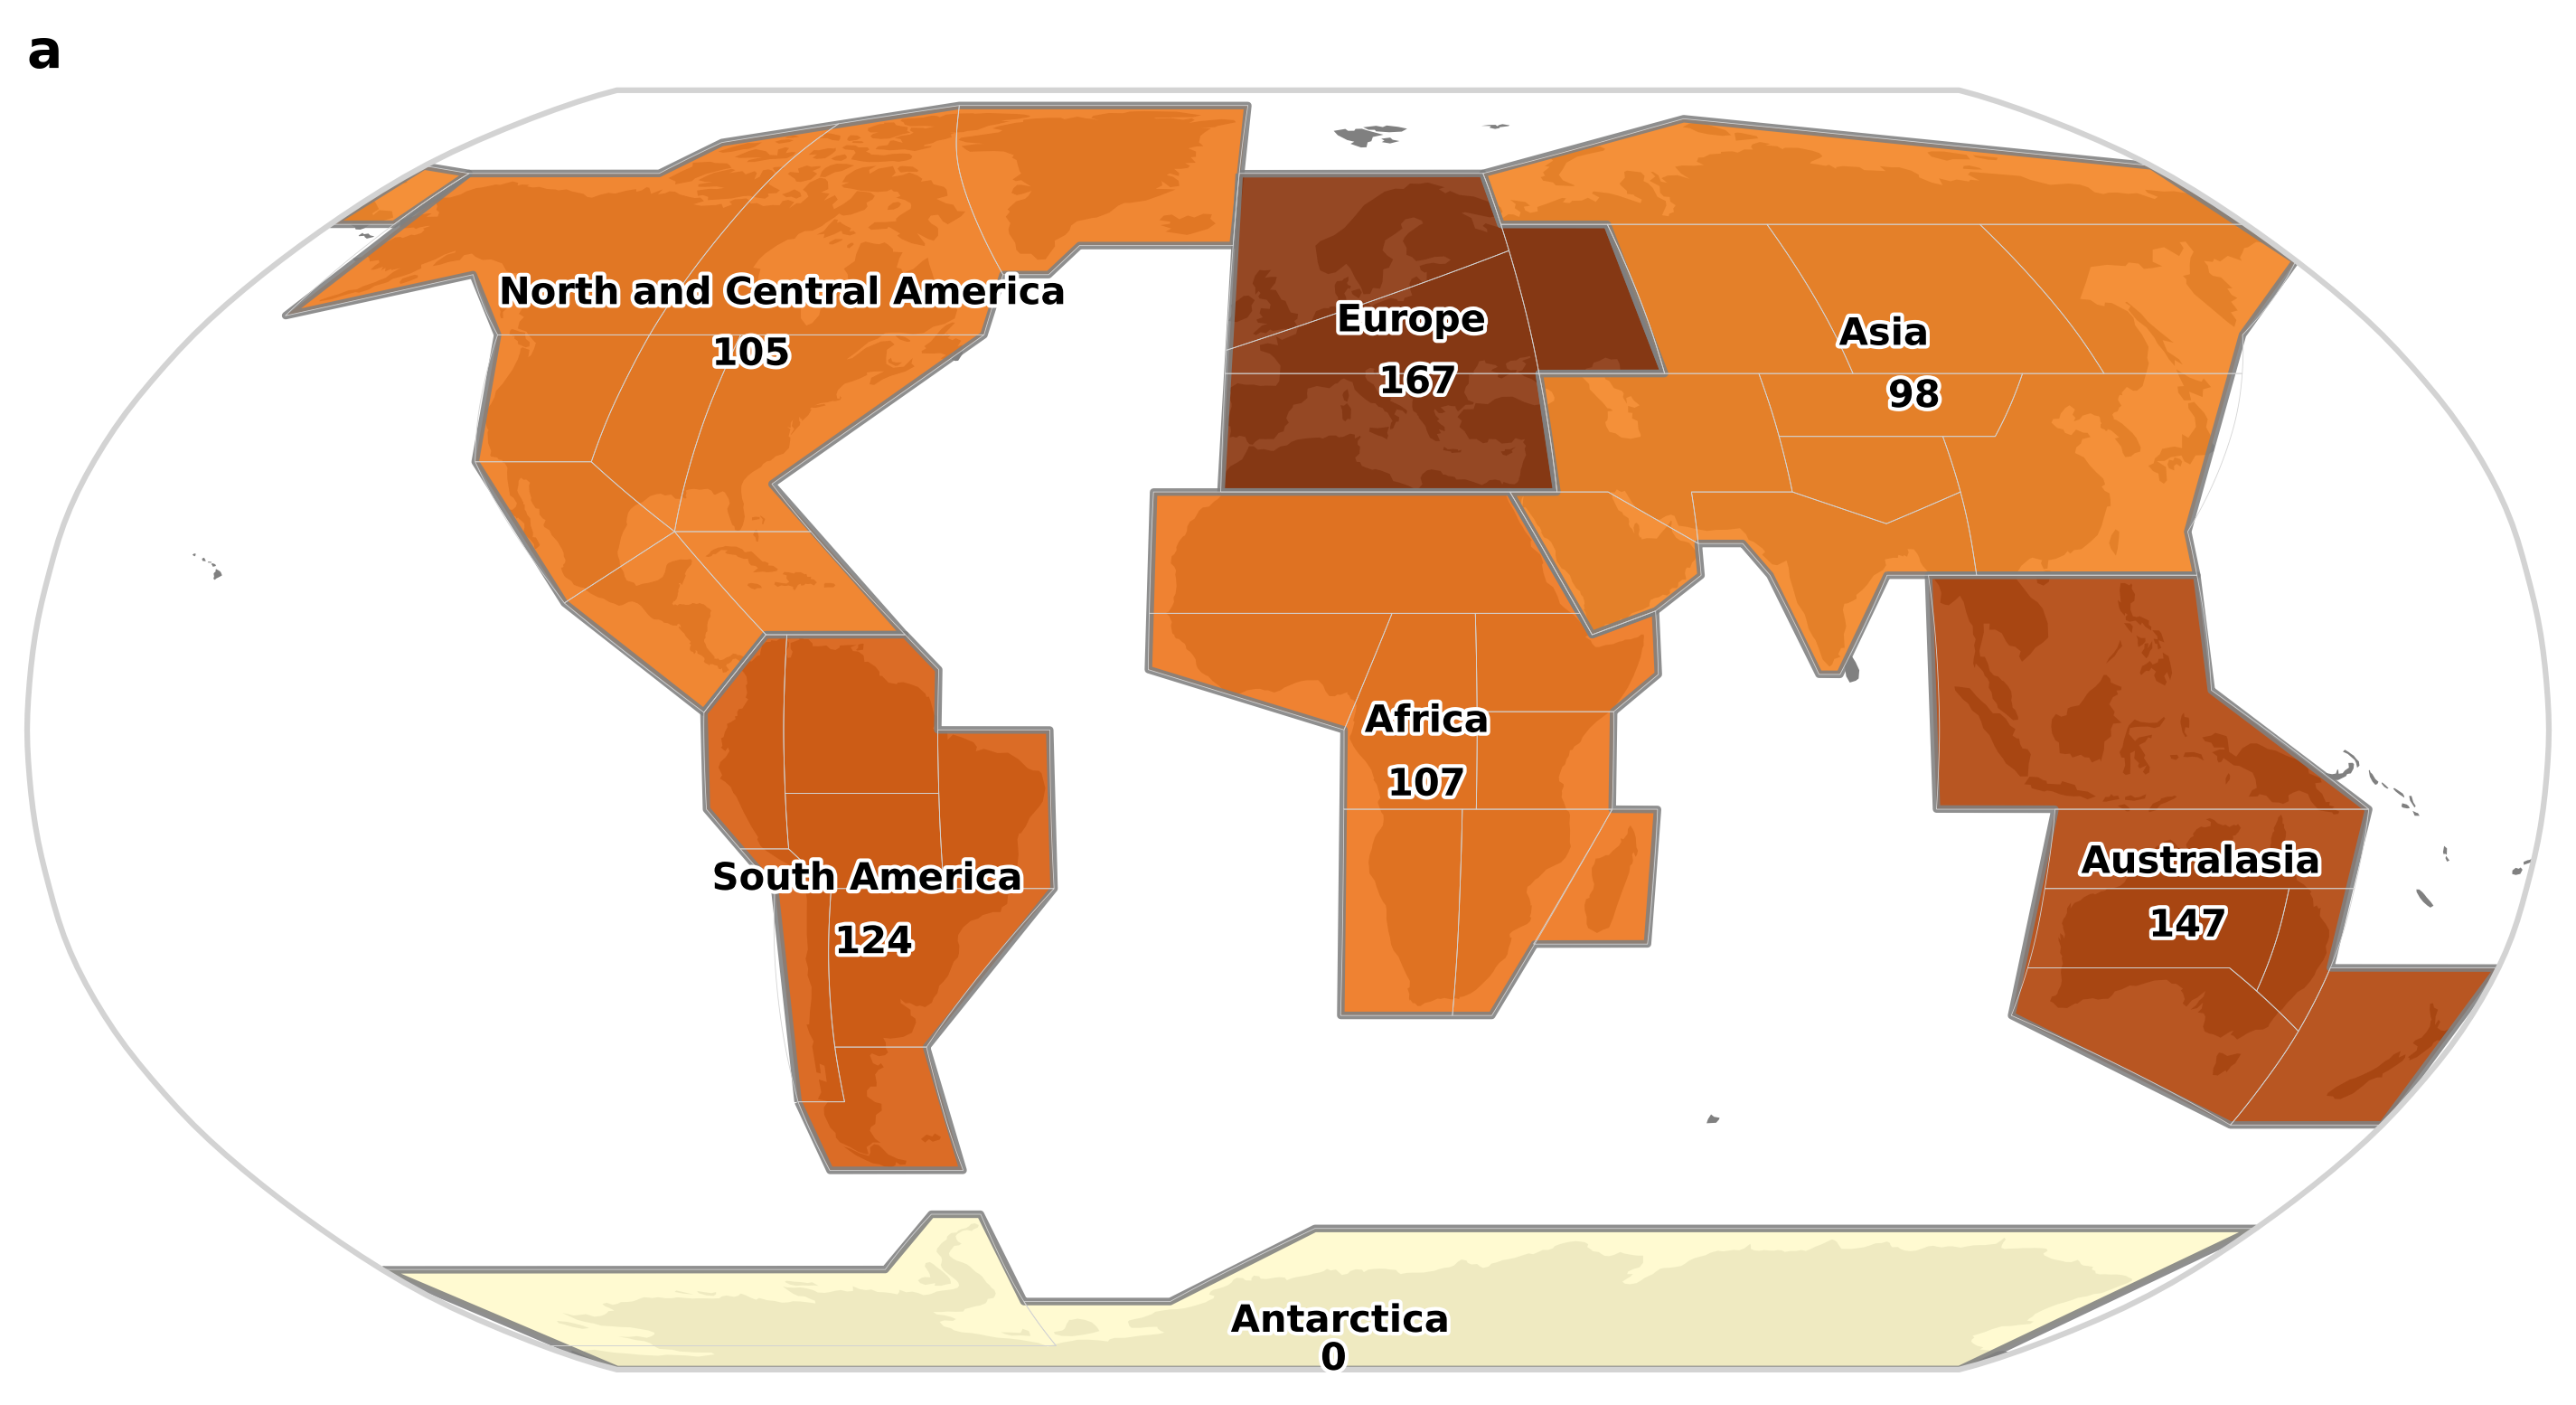

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a colormap
norm = mcolors.Normalize(vmin=nan_year_continent.min().item(), 
                         vmax=nan_year_continent.max().item())

fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(projection=ccrs.Robinson()), dpi = 300)

ax.spines['geo'].set_edgecolor("lightgray")
ax.spines['geo'].set_linewidth(1.5)

# Land background
ax.add_feature(cfeature.LAND, facecolor="gray",linewidth=0, edgecolor="none", zorder=0, alpha = 1)
ax.set_global()

# Merge nan_year_continent values into continent_gdf
continent_gdf_plot = continent_gdf.copy()
continent_gdf_plot['count'] = continent_gdf_plot['continent'].map(
    lambda x: nan_year_continent.sel(continent=x).values.item()
)

# Plot continents with shading based on count
continent_gdf_plot.to_crs(proj.proj4_init).plot(
    ax=ax,
    edgecolor="gray",
    facecolor=continent_gdf_plot['count'].apply(lambda x: truncated_cmap(norm(x))),
    linewidth=2,
    alpha=0.88,
    zorder=2
)

# Optional: light AR6 internal boundaries
ar6_gdf.to_crs(proj.proj4_init).boundary.plot(
    ax=ax,
    edgecolor="lightgray",
    linewidth=0.2,
    zorder=3
)

# Add continent labels and counts
for idx, row in continent_gdf_plot.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    
    # Continent name
    ax.text(x, y, row['continent'], ha='center', va='center',
            fontsize=10, fontweight='bold', color='black',
            transform=ccrs.PlateCarree(), path_effects=[pe.withStroke(linewidth=2, foreground="w")])
    
    # Count
    ax.text(x, y-8, str(row['count']), ha='center', va='center',
            fontsize=10, fontweight='bold', color='black',
            transform=ccrs.PlateCarree(), path_effects=[pe.withStroke(linewidth=2, foreground="w")])

plt.title(
    "a",
    loc="left",
    fontsize=14,
    fontdict={"size": "large", "weight": "bold"}
)
plt.show()

### Global land

In [22]:
result = compute_global_ar6_mean(tas_had_yr_75per, threshold=0.3)

global_ar6_mean_mask = result["global_ar6_mean_masked"]
grid_fraction = result["grid_fraction"]

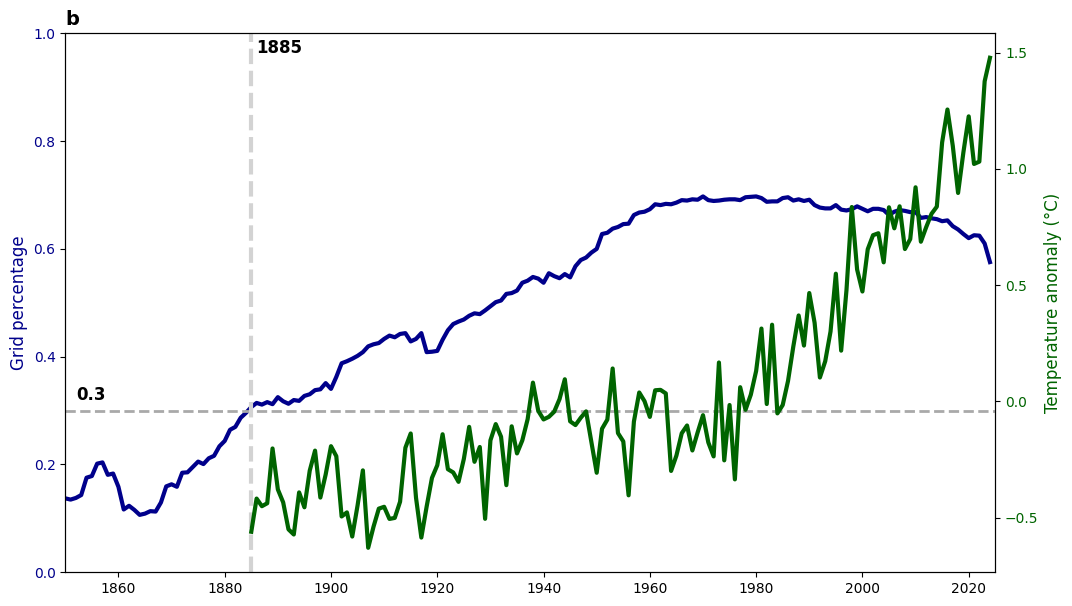

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Left y-axis (ratio) ---
ax1.plot(
    grid_fraction["year"],
    grid_fraction,
    color="darkblue",
    lw=3,
    label="Grid ratio"
)
ax1.axhline(0.3, color="darkgray", linestyle="--", linewidth=2)
ax1.set_ylim(0, 1)
ax1.set_ylabel("Grid percentage", color="darkblue", fontsize = 12)
ax1.tick_params(axis="y", labelcolor="darkblue")

# --- Right y-axis (temperature anomaly) ---
ax2 = ax1.twinx()
ax2.plot(
    global_ar6_mean_mask["year"],
    global_ar6_mean_mask,
    color="darkgreen",
    lw=3,
    label="Temperature anomaly"
)
ax2.set_xlim(1850, 2025)
ax2.set_ylabel("Temperature anomaly (°C)", color="darkgreen", fontsize = 12)
ax2.tick_params(axis="y", labelcolor="darkgreen")

ax1.text(1852, 0.32, '0.3', weight = 'bold', fontsize = 12)

not_nan_1st_year = global_ar6_mean_mask.where(
    global_ar6_mean_mask.notnull(), drop=True
).isel(year=0)['year']

ax1.axvline(not_nan_1st_year, color="lightgray", linestyle="--", linewidth=3)
ax1.text(not_nan_1st_year + 1, 0.99, not_nan_1st_year.values, va = 'top', weight = 'bold', fontsize = 12)

# --- Title ---
plt.title("b", fontsize=14, fontweight="bold", loc = 'left')

plt.show()

### Combine the AR6, continent and global mean HadCRUT5 data

In [24]:
continent_to_abbrev = {
    "Asia": "Asia",
    "North and Central America": "NA",
    "Europe": "EU",
    "Africa": "AF",
    "South America": "SA",
    "Australasia": "AU",
    "Antarctica": "ANT",
}

ar6_data = tas_regional_mask_AR6_had
cont_data = tas_continent_mask
global_data = global_ar6_mean_mask

had_ar6_cont_glob = combine_ar6_continent_global(
    ar6_data,
    cont_data,
    global_data
)

had_ar6_cont_glob

<xarray.DataArray 'tas_mean' (year: 175, region: 54)> Size: 76kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.70618454,        nan,
        1.03089099],
       [       nan,        nan,        nan, ..., 0.71725137,        nan,
        1.37630137],
       [       nan,        nan,        nan, ..., 0.88603003,        nan,
        1.47740056]], shape=(175, 54))
Coordinates:
    realization  int64 8B 100
  * year         (year) int64 1kB 1850 1851 1852 1853 ... 2021 2022 2023 2024
  * region       (region) int64 432B 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
    abbrevs      (region) <U4 864B 'GIC' 'NWN' 'NEN' 'WNA' ... 'AU' 'ANT' 'LSAT'
    names        (region) <U25 5kB 'Greenland/Iceland' ... 'Global Land'

### Save data

In [25]:
path = './saved_data/'
name = '0.1.HadCRUT5.Tas.anomalies.46AR6regions_7cont_1glob_175years_1850-2024.pkl'
with open(path + name, 'wb') as wi:
	pickle.dump(had_ar6_cont_glob, wi)